<a href="https://colab.research.google.com/github/vaibhav-prasad707/DeepSeek_LSTM/blob/main/LSTM_DeepSeek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

In [2]:
pip install pandas

In [3]:
pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 10.8 MB/s eta 0:00:00


In [4]:
pip install tensorflow

In [5]:
pip install numpy

In [6]:
pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Fetch NVDA historical data
nvda = yf.Ticker("NVDA")
df = nvda.history(period="5y")

# Add DeepSeek R1 event (release date: 2025-01-20, market crash: 2025-01-28)
df['DeepSeek_Event'] = 0
df.loc['2025-01-20':, 'DeepSeek_Event'] = 1  # Event window

# Add sentiment score (example placeholder)
# Use news sentiment scraper here in practice
df['Sentiment'] = 0
df.loc['2025-01-20':, 'Sentiment'] = -0.8  # Negative sentiment from news:cite[1]:cite[10]

<ipython-input-7-235c91bfd24e>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc['2025-01-20':, 'Sentiment'] = -0.8  # Negative sentiment from news:cite[1]:cite[10]


In [8]:
# Calculate technical indicators
df['MA_7'] = df['Close'].rolling(7).mean()
df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(14).mean() /
                              df['Close'].diff().clip(upper=0).abs().rolling(14).mean())))

# Lag features
for lag in [1, 2, 3, 4, 5]:
    df[f'Lag_{lag}'] = df['Close'].shift(lag)

# Drop NaN rows
df.dropna(inplace=True)

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'MA_7', 'RSI', 'DeepSeek_Event', 'Sentiment']])

# Prepare sequences
X, y = [], []
sequence_length = 10  # 10-day window

for i in range(len(scaled_data) - sequence_length - 5):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+5, 0])  # Predict next 5 days

X, y = np.array(X), np.array(y)

# Split data (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    LSTM(32),
    Dense(5)  # Predict 5 days ahead
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0071 - val_loss: 0.0166
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8859e-04 - val_loss: 7.0740e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6101e-04 - val_loss: 6.3329e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4754e-04 - val_loss: 6.0107e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4049e-04 - val_loss: 6.3773e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4607e-04 - val_loss: 6.9717e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6426e-04 - val_loss: 5.8222e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4645e-04 - val_loss: 5.9554e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6856e-04 - val_loss: 6.1145e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1759e-04 - val_loss: 6.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


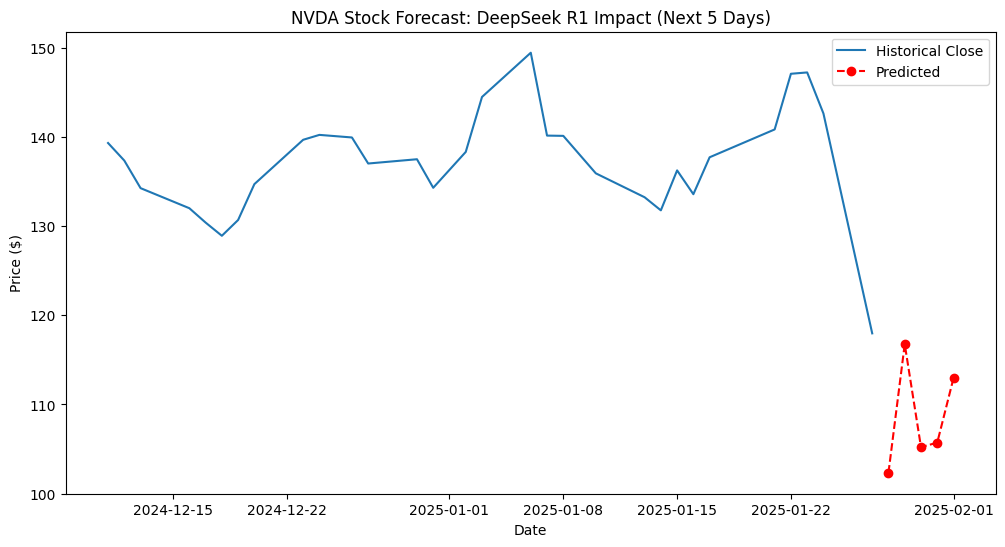

In [10]:
# Use the latest sequence for prediction
latest_sequence = scaled_data[-sequence_length:]
prediction = model.predict(np.array([latest_sequence]))

# Inverse-transform predictions
prediction = scaler.inverse_transform(
    np.concatenate([prediction[0].reshape(-1,1), np.zeros((5,4))], axis=1)
)[:,0]

# Create prediction dates
last_date = df.index[-1]
pred_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index[-30:], df['Close'][-30:], label='Historical Close')
plt.plot(pred_dates, prediction, marker='o', linestyle='--', color='red', label='Predicted')
plt.title('NVDA Stock Forecast: DeepSeek R1 Impact (Next 5 Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()